In [1]:
import sys
import torch

print(f"Python executable: {sys.executable}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Python executable: /home/prashant/repo/public/sam3-cpu/.venv/bin/python
CUDA available: False


In [2]:
import os
import sam3

sam3_root = os.path.join(os.path.dirname(sam3.__file__))
device = "cuda" if torch.cuda.is_available() else "cpu"

INFO 2026-02-25 13:31:25,260 323604 __globals.py:  12: Python executable: /home/prashant/repo/public/sam3-cpu/.venv/bin/python
INFO 2026-02-25 13:31:25,260 323604 __globals.py:  13: CUDA available: False
INFO 2026-02-25 13:31:25,261 323604 __globals.py:  25: ⚡ Profiling DISABLED (use --profile to enable)



In [3]:
bpe_path = os.path.join(sam3_root, "assets/bpe_simple_vocab_16e6.txt.gz")
num_workers = 1 if device == "cpu" else 0
if device == "cpu":
    from sam3.model_builder import build_sam3_video_predictor_cpu
    print("Running on CPU. For better performance, please run on a GPU.")
    predictor = build_sam3_video_predictor_cpu(bpe_path=bpe_path, num_workers=num_workers)
else:
    from sam3.model_builder import build_sam3_video_predictor
    print("Running on GPU")
    predictor = build_sam3_video_predictor()

INFO 2026-02-25 13:31:35,053 323604 sam3_video_predictor_v2.py: 555: using 1 CPU workers for parallel inference
INFO 2026-02-25 13:31:35,054 323604 sam3_video_predictor_v2.py: 570: 


	*** START loading model on all ranks ***


INFO 2026-02-25 13:31:35,055 323604 sam3_video_predictor_v2.py: 572: loading model on rank=0 with world_size=1 -- this could take a while ...


Running on CPU. For better performance, please run on a GPU.


INFO 2026-02-25 13:31:40,141 323604 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-25 13:31:41,540 323604 sam3_video_predictor_v2.py: 576: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-02-25 13:31:41,541 323604 sam3_video_predictor_v2.py: 586: 


	*** DONE loading model on all ranks ***




# Inference and visualisation Utils

In [ ]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
            start_frame_index=0,
            max_frame_num_to_track=30
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

## Video chunks

In [8]:
video_chunk_path = os.path.join(sam3_root, "../assets/videos/private/feb4_camera10_chunks/")

video_cunks = sorted(glob.glob(os.path.join(video_chunk_path, "*.mp4")))
print(f"Found {len(video_cunks)} video chunks in {video_chunk_path}")

Found 5 video chunks in /home/prashant/repo/public/sam3-cpu/sam3/../assets/videos/private/feb4_camera10_chunks/


In [9]:
idx = 0

In [10]:
video_path = video_cunks[idx]
print(f"Processing video chunk: {video_path}")

Processing video chunk: /home/prashant/repo/public/sam3-cpu/sam3/../assets/videos/private/feb4_camera10_chunks/chunk_000.mp4


In [11]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

## Opening an inference session on this video

In [12]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]: 100%|██████████| 775/775 [00:00<00:00, 1009.75it/s]


## Video promptable concept segmentation with text

In [18]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

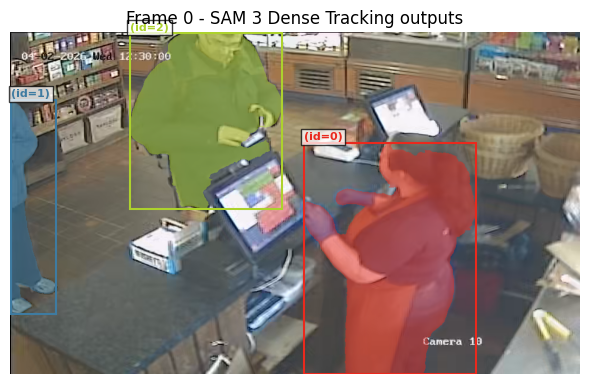

In [20]:
# prompt_text_str = "player holding a tennis racket"  # this is the text prompt we want to add on frame 0
prompt_text_str = "person"
# prompts = ["player holding a tennis racket", "tennis racket", "ball"]  # you can also specify multiple prompts at once
frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

propagate_in_video:   0%|          | 0/775 [00:00<?, ?it/s]

0it [00:00, ?it/s]

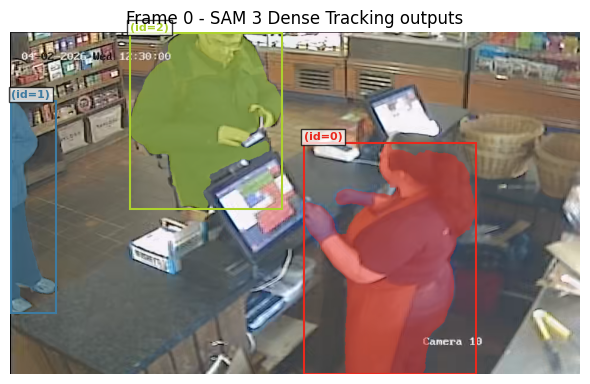

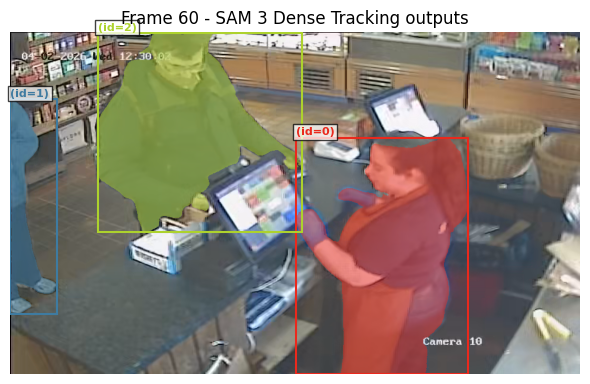

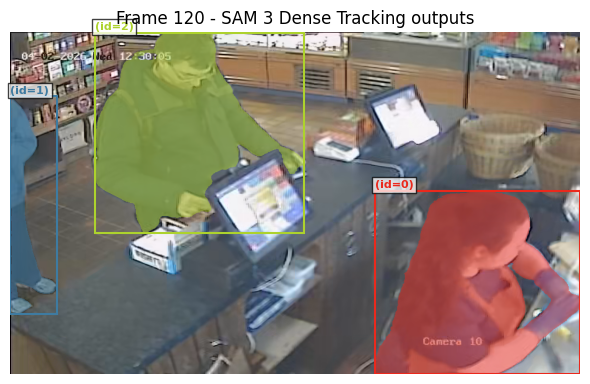

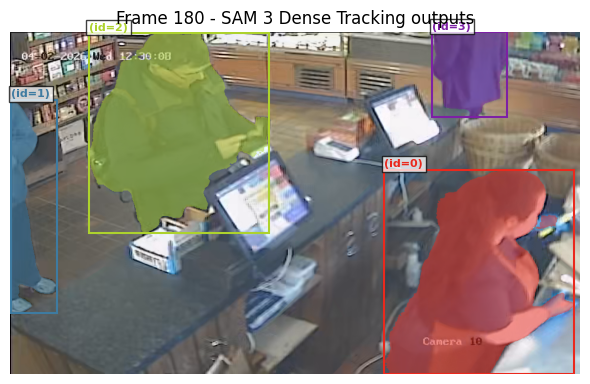

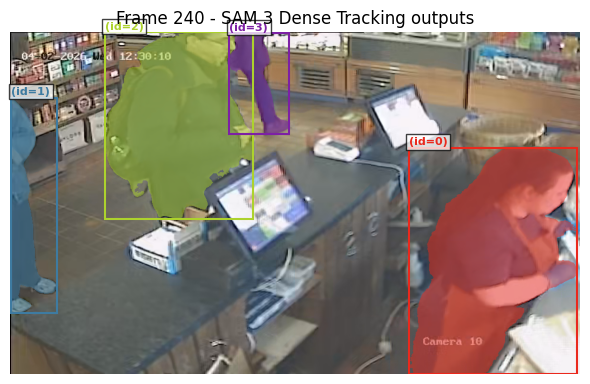

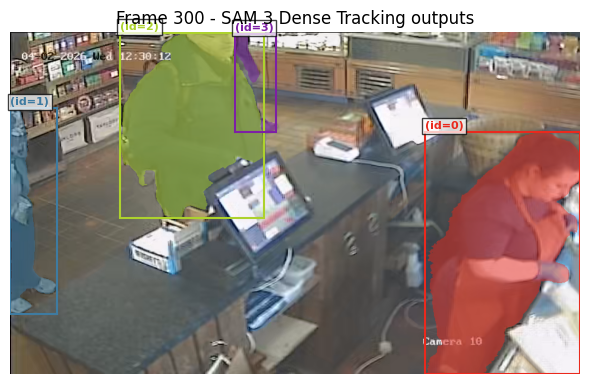

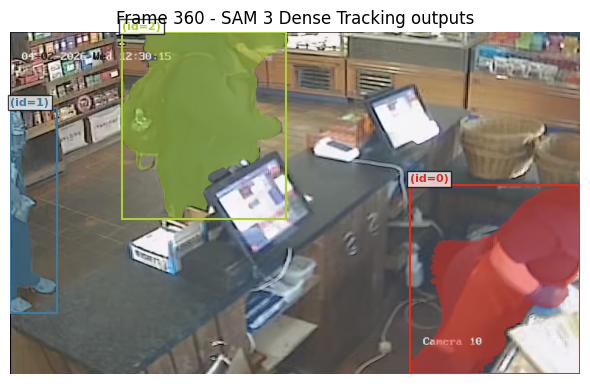

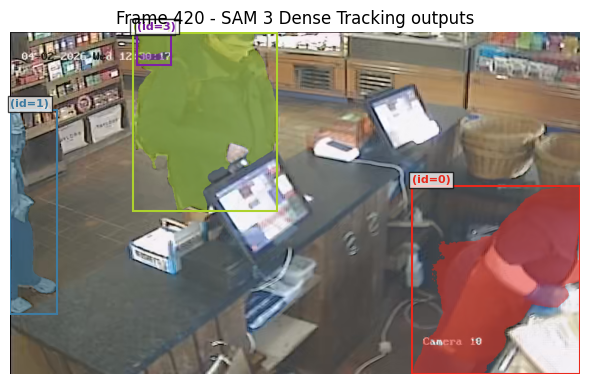

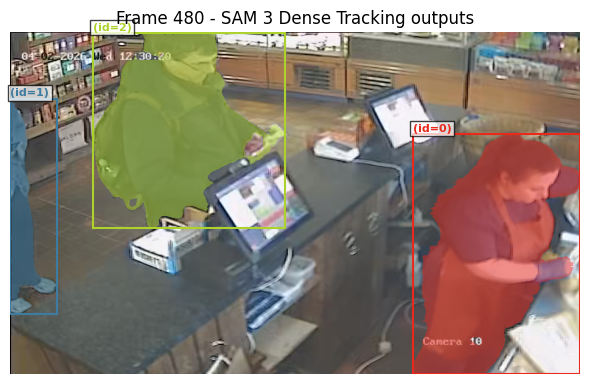

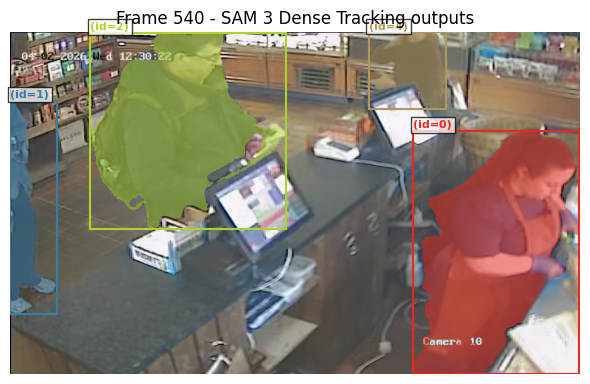

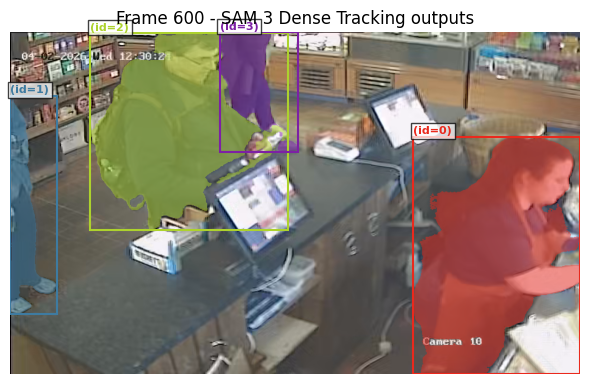

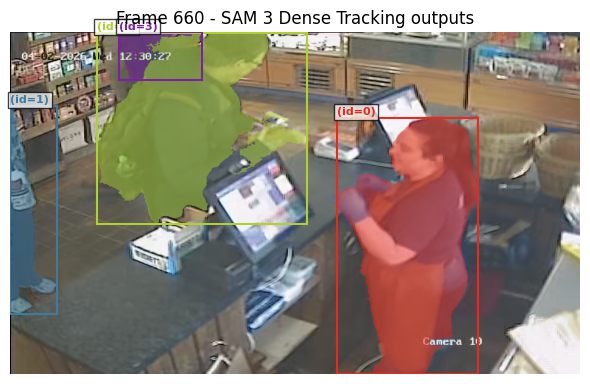

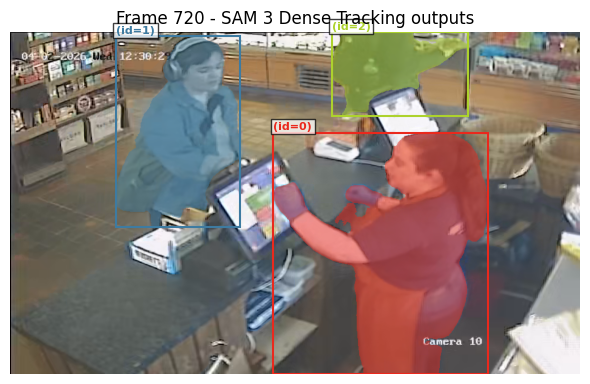

In [21]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )